In [1]:
from argparse import ArgumentParser
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
import random

In [15]:
lr = 1e-4
n_epochs = 5
batch_size = 32
noise_dim = 32
img_dim = 28 * 28 * 1
hidden_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layers = [
            nn.Linear(noise_dim, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, img_dim),
        ]
        
        layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.02),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        return self.model(flattened)

In [19]:
def train_gan(n_epochs, train_loader): 
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    optim_g = optim.Adam(generator.parameters(), lr=lr)
    optim_d = optim.Adam(discriminator.parameters(), lr=lr)

    criterion = nn.BCELoss()
    optim_d = optim.Adam(discriminator.parameters(), lr=2e-4)
    optim_g = optim.Adam(generator.parameters(), lr=2e-4)
    d_losses, g_losses = [], []
    
    for epoch in range(n_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)
            real_images = real_images.view(current_batch_size, -1)

            optim_d.zero_grad()

            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(current_batch_size, noise_dim).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach())  
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optim_d.step()

            optim_g.zero_grad()

            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optim_g.step()
            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            g_loss = criterion(outputs, real_labels)
            g_losses.append(g_loss.item())

            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(train_loader)}], '
                    f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

    print('Training finished.')

    plt.figure(figsize=(10, 5))
    plt.title("g & d loss during training")
    plt.plot(g_losses, label="g loss")
    plt.plot(d_losses, label="d loss")
    plt.xlabel("itrs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return d_losses, g_losses

Epoch [1/5], Step [200/1875], D Loss: 0.2397, G Loss: 3.3112
Epoch [1/5], Step [400/1875], D Loss: 0.0640, G Loss: 4.9906
Epoch [1/5], Step [600/1875], D Loss: 0.0253, G Loss: 5.4154
Epoch [1/5], Step [800/1875], D Loss: 0.0508, G Loss: 6.6511
Epoch [1/5], Step [1000/1875], D Loss: 0.0557, G Loss: 4.7516
Epoch [1/5], Step [1200/1875], D Loss: 0.0084, G Loss: 7.0086
Epoch [1/5], Step [1400/1875], D Loss: 0.0782, G Loss: 3.7551
Epoch [1/5], Step [1600/1875], D Loss: 0.0841, G Loss: 4.4524
Epoch [1/5], Step [1800/1875], D Loss: 0.0448, G Loss: 4.6827
Epoch [2/5], Step [200/1875], D Loss: 0.0178, G Loss: 5.9333
Epoch [2/5], Step [400/1875], D Loss: 0.1219, G Loss: 5.1302
Epoch [2/5], Step [600/1875], D Loss: 0.2101, G Loss: 5.3600
Epoch [2/5], Step [800/1875], D Loss: 0.0874, G Loss: 5.4500
Epoch [2/5], Step [1000/1875], D Loss: 0.2231, G Loss: 5.1962
Epoch [2/5], Step [1200/1875], D Loss: 0.1563, G Loss: 7.5678
Epoch [2/5], Step [1400/1875], D Loss: 0.2041, G Loss: 3.4833
Epoch [2/5], Ste

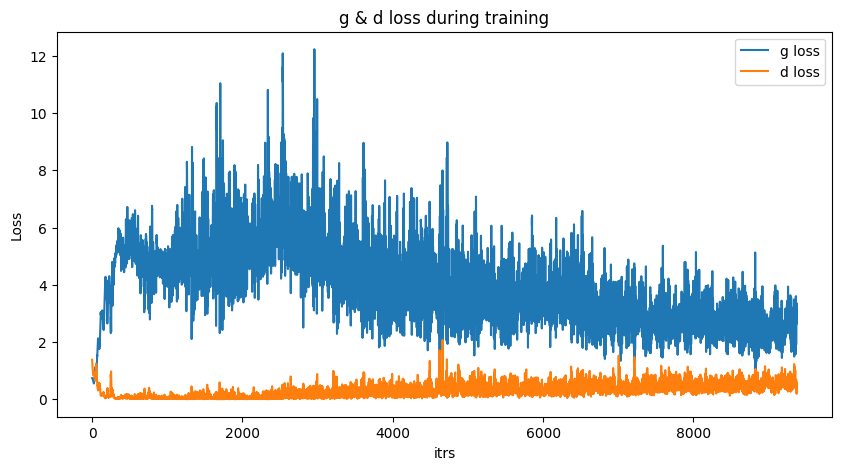

<Figure size 1500x800 with 0 Axes>

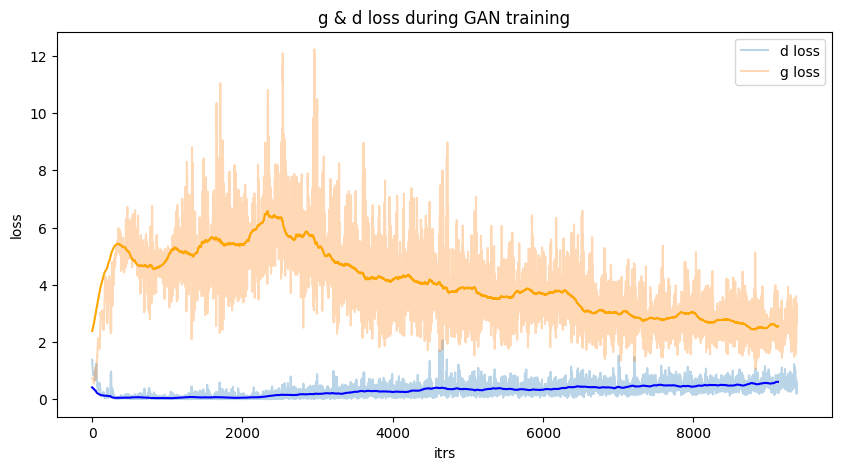

In [20]:
d_losses, g_losses = train_gan(n_epochs, train_loader)

plt.figure(figsize=(15, 8))

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)

window_size = 250 
d_losses_moving_avg = moving_average(d_losses, window_size)
g_losses_moving_avg = moving_average(g_losses, window_size)

plt.figure(figsize=(10, 5))
plt.title("g & d loss during GAN training")

plt.plot(d_losses, label="d loss", alpha=0.3)
plt.plot(g_losses, label="g loss", alpha=0.3)

plt.plot(d_losses_moving_avg, color="blue")
plt.plot(g_losses_moving_avg, color="orange")

plt.xlabel("itrs")
plt.ylabel("loss")
plt.legend()
plt.show()